# PyZX interoperability: a simple graph

In [11]:
import os
import sys
import pyzx as zx

from topologiq.scripts.runner import runner
from topologiq.utils.interop_pyzx import pyzx_g_to_simple_g
from topologiq.utils.utils_zx_graphs import kind_to_zx_type

repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

zx.settings.colors = zx.rgb_colors
%matplotlib widget

This notebook offers an example of how to use ***topologiq*** to perform an algorithmic lattice surgery of a simple PyZX graph.

## Input: Preparing a PyZX graph

We'll use a simple PyZX graph for this notebook, consisting of three CNOTs but, in theory, ***topologiq*** can take any PyZX graph as long as all qubit lines interconnect (disconnected qubit lines mean the PyZX graph has subgraphs / separate logical computations, in which case only one subgraph is considered).

Note that while we draw the graph using `zx.draw()`, we also save the matplotlib figure separately. We'll use it later.

In [12]:
circuit_name = "pyzx_example_cnots"

c = zx.Circuit(2)
c.add_gate("CNOT", 0, 1)
c.add_gate("CNOT", 1, 0)
c.add_gate("CNOT", 1, 0)

pyzx_graph = c.to_graph()

zx.draw(pyzx_graph, labels=True)
fig_data = zx.draw_matplotlib(pyzx_graph, labels=True)

## Process: Running the algorithm

PyZX graphs have information that that is not needed to undertake the foundatoinal placement of spiders in a 3D space. So, we first need to convert the PyZX graph into ***topologiq***'s native format, a `simple_graph`: a simple dictionary of nodes and edges.

There is a single instruction to distill a PyZX graph into a `simple_graph`. It undertakes all steps below:
- Dump the entire PyZX graph into a dictionary using PyZX internal methods,
- Transform into a dictionary with clear syntax for 3D positioning but all values zeroed out,
- Distill the 3D dictionary into a simpler dictionary for consumption by the algorithm.

In [13]:
simple_graph = pyzx_g_to_simple_g(pyzx_graph)
print(simple_graph)

{'nodes': [(0, 'O'), (1, 'O'), (2, 'X'), (3, 'Z'), (4, 'X'), (5, 'Z'), (6, 'X'), (7, 'Z'), (8, 'O'), (9, 'O')], 'edges': [((0, 3), 'SIMPLE'), ((1, 2), 'SIMPLE'), ((2, 3), 'SIMPLE'), ((2, 5), 'SIMPLE'), ((3, 4), 'SIMPLE'), ((4, 5), 'SIMPLE'), ((4, 6), 'SIMPLE'), ((5, 7), 'SIMPLE'), ((6, 7), 'SIMPLE'), ((6, 8), 'SIMPLE'), ((7, 9), 'SIMPLE')]}


The next step is to feed the `simple_graph` to ***topologiq*** and let it undertake algorithmic lattice surgery of the circuit.

In short, ***topologiq*** will traverse that graph using a Breadth-First Search (BFS) approach and exchange all spiders and edges in the original graph for a 3D version of themselves.

If/when the lattice surgery is complete, ***topologiq*** will produce:
- text results saved to `[root]/output/txt/` that includes the final surgery/space-time diagram,
- and related objects for programmatic use.

Additional visualisations options are available but come at a significant cost in runtimes. Check ***topologiq***'s [README](../../README.md) for details.

> **Note.** The visualisation in this notebook shows the final result, but you can get step by step visuals by changing `visualise=("final", None)` to `visualise=("detail", None)`. Additionally, ***topologiq*** can also produce an animated GIF summary of the surgery: use `visualise=("final", "GIF")` or `visualise=("final", "MP4")` (MP4 production requires FFmpeg to be installed separately). Be aware visualisations can consume significant computing resources and will significantly impact runtimes.

.
SUCCESS!!! Volume: 14. Duration: 0.16s (attempt), 0.16s (total).
Visualisations enabled. For faster runtimes, disable visualisations.


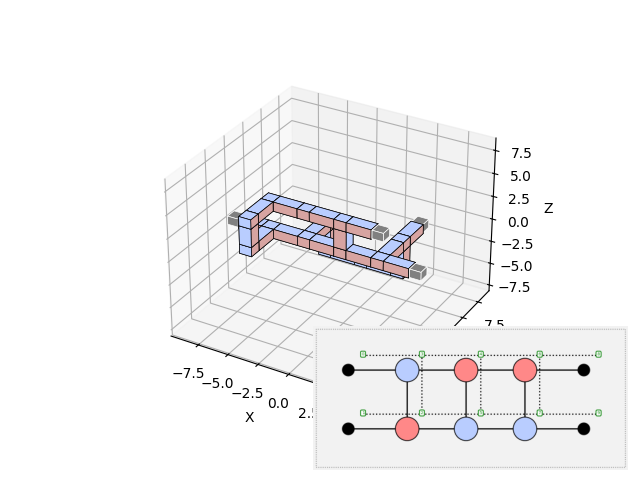

In [14]:
# Define weights for the value function to to choose best of several valid paths per each edge based on: (length of path, number of beams broken by path)
# A negative value for length of path favours short paths.
# A negative value for number of beams broken by path favours placements that do not block potential open faces requiring connections.
VALUE_FUNCTION_HYPERPARAMS = (-1, -1)

# Define a desired length of beams
# The longer the beams, the more space between faces. This feature needs improvement but, in theory, increases the odds of success.
# Needs to be combined with an equal or larger `MAX_PATHFINDER_SEARCH_SPACE`
LENGTH_OF_BEAMS = 9

kwargs = {
    "weights": VALUE_FUNCTION_HYPERPARAMS,
    "length_of_beams": LENGTH_OF_BEAMS,
}

zx.draw(pyzx_graph, labels=True)

simple_graph_after_use, edge_paths, lattice_nodes, lattice_edges = runner(
    simple_graph,
    circuit_name,
    strip_boundaries=False,
    hide_boundaries=False,
    max_attempts=10,
    vis_options=("final", None),
    fig_data=fig_data,  # This is where we use the fig_data from PyZX, so it's overlaid on top of progress and final visualisations
    **kwargs
)

## Output: Using outputs

The algorithm returns four objects:
- `simple_graph_after_use`: the original `simple_graph`, returned for convenience.
- `edge_paths`: a set of 3D edges where each edge corresponds to the original edges in the ZX graph but where the "nodes" have been exchanged for all 3D blocks and pipes needed to clear the edge in a 3D space (contains redundant nodes across edges).
- `lattice_nodes`: all nodes in `edge_paths` distilled into a single lattice surgery / space-time diagram object.
- `lattice_edges`: all edges in `edge_paths` distilled into a single lattice surgery / space-time diagram object.

These objects can be used variously.

For instance, with more complex graphs, it is possible to link information in the original PyZX graph with the results in these objects.

Having said that, since the circuit in this notebook is very simple, we will now limit ourselves to taking a closer look at how each edge is constructed, by comparing the original PyZX graph with the `edge_paths` object.

In [15]:
zx.draw(pyzx_graph, labels=True)

if edge_paths:
    for key, edge in edge_paths.items():
        block_by_block = []
        nodes_and_edges = []
        for node in edge["path_nodes"]:
            block_by_block.append(node[1])
            nodes_and_edges.append(kind_to_zx_type(node[1]))
        print(f"{key}: {'-'.join(block_by_block)} ({' - '.join(nodes_and_edges)})")

(3, 4): zxz-oxz-xxz (X - SIMPLE - Z)
(4, 5): zxz-oxz-xxz (X - SIMPLE - Z)
(4, 6): zxz-zxo-zxz (X - SIMPLE - X)
(0, 3): xxz-oxz-ooo (Z - SIMPLE - BOUNDARY)
(2, 3): xxz-xoz-xzz (Z - SIMPLE - X)
(5, 7): xxz-oxz-xxz (Z - SIMPLE - Z)
(6, 8): zxz-oxz-ooo (X - SIMPLE - BOUNDARY)
(1, 2): xzz-xoz-ooo (X - SIMPLE - BOUNDARY)
(7, 9): xxz-oxz-ooo (Z - SIMPLE - BOUNDARY)
(2, 5): xzz-xzo-xzx-ozx-zzx-ozx-xzx-xzo-xzz-xoz-xxz (X - SIMPLE - Z - SIMPLE - X - SIMPLE - Z - SIMPLE - X - SIMPLE - Z)
(6, 7): zxz-oxz-xxz-oxz-xxz-xoz-xzz-xzo-xzz-xoz-xxz (X - SIMPLE - Z - SIMPLE - Z - SIMPLE - X - SIMPLE - X - SIMPLE - Z)
